# Grover
Grover's search algorithm is one of the more straightforward quantum algorithms for solving an actual problem using quantum computing quadratically faster than its classical counterpart. This exercise is losely based on the [Grover's algorithm and its Qiskit implementation Qiskit tutorial](https://quantum-computing.ibm.com/support/guides/quantum-algorithms-with-qiskit?page=5cc0d9fd86b50d00642353ca#experiment-with-simulators), which goes inte greater detail regarding the implementation and theory.

What we will demonstrate is an unstructured search of a database, using the so called amplitude amplification trick.

Let's start by importing the IBMQ method and load our account.

In [1]:
#initialization
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# importing Qiskit
from qiskit import IBMQ, BasicAer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute


In [2]:
# Import visualization
from qiskit.visualization import plot_histogram, plot_bloch_multivector, iplot_bloch_multivector, plot_state_qsphere, iplot_state_qsphere

# Add the state vector calculation function
def get_psi(circuit, vis="B"): 
    global psi
    backend = BasicAer.get_backend('statevector_simulator') 
    psi = execute(circuit, backend).result().get_statevector(circuit)
    if vis=="Q":
        display(iplot_state_qsphere(psi))
    elif vis=="q":
        display(plot_state_qsphere(psi))
    elif vis=="M":
        print(psi)
    elif vis=="b":
        display(plot_state_qsphere(psi))
    else: # vis="B"
        display(iplot_bloch_multivector(psi))
        
    vis=""

Set the number of qubits for the Grover circuit.

In [3]:
n_qubits=3
oracle_n=2

We create a phase oracle that will mark states (|000⟩ and 
|111⟩) as the results (step 1).

In [4]:
from qiskit.quantum_info.operators import Operator

# Two qubit oracle - with the answer |01>
unitary_oracle_0 = Operator([
    [-1, 0, 0, 0],
    [0, -1, 0, 0],
    [0, 0, -1, 0],
    [0, 0, 0, 1]])

# Three qubit oracle - with the answer |000> and |111>
unitary_oracle_1 = Operator([
    [ -1,  0,  0,  0,  0,  0,  0,  0],
    [ 0, -1,  0,  0,  0,  0,  0,  0],
    [ 0,  0, -1,  0,  0,  0,  0,  0], 
    [ 0,  0,  0, -1,  0,  0,  0,  0], 
    [ 0,  0,  0,  0, -1,  0,  0,  0], 
    [ 0,  0,  0,  0,  0, -1,  0,  0], 
    [ 0,  0,  0,  0,  0,  0, -1,  0], 
    [ 0,  0,  0,  0,  0,  0,  0, 1]])
    
# Append the appropriate unitary operator
def phase_oracle(circuit, register):
    if n_qubits == 3:
        circuit.append(unitary_oracle_1,qr)
    else:
        circuit.append(unitary_oracle_0,qr)
    display(print(unitary_oracle_1.is_unitary()))
    circuit.barrier(qr)
    display(circuit.draw(output="mpl"))

    
    
def phase_oracle2(circuit, register):
    if n_qubits == 3:
        circuit.z(qr)
        circuit.cz(qr[1],qr[0])
        circuit.cz(qr[2],qr[0])
        circuit.cz(qr[2],qr[1])
    else:
        circuit.z(qr)
        circuit.cz(qr[0],qr[1])
    circuit.barrier(qr)
    display(circuit.draw(output="mpl"))



Next we set up the circuit for inversion about the average (step 2), where we will first need to define a function that creates a multiple-controlled Z gate.

In [5]:
def n_controlled_Z(circuit, controls, target):
    """Implement a Z gate with multiple controls"""
    if (len(controls) > 2):
        raise ValueError('The controlled Z with more than 2 controls is not implemented')
    elif (len(controls) == 1):
        circuit.h(target)
        circuit.cx(controls[0], target)
        circuit.h(target)
    elif (len(controls) == 2):
        circuit.h(target)
        circuit.ccx(controls[0], controls[1], target)
        circuit.h(target)

...

In [6]:
def inversion_about_average(circuit, register, n):
    """Apply inversion about the average step of Grover's algorithm."""
    circuit.h(register)
    circuit.x(register)
    n_controlled_Z(circuit, [register[j] for j in range(n-1)], register[n-1])
    circuit.x(register)
    circuit.h(register)
    circuit.barrier(qr)


Create the initial all-Hadamard circuit.

In [11]:
qr = QuantumRegister(n_qubits)
cr = ClassicalRegister(n_qubits)
groverCircuit = QuantumCircuit(qr,cr)
groverCircuit.h(qr)
groverCircuit.barrier(qr)
groverCircuit.draw(output="mpl")
get_psi(groverCircuit,"Q")

None

And now build the final Grover circuit by adding in the oracle, the inversion circuitm and the measurement gates. We will display the phase changes as we move though building the circuit.

2


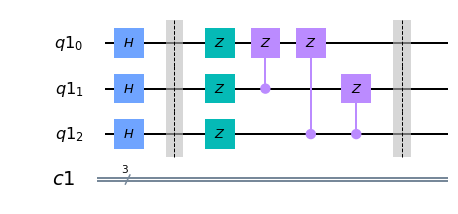

None

In [12]:
print(oracle_n)
if oracle_n==1:
    phase_oracle(groverCircuit, qr) #<- Add the oracle/black box
else:
    phase_oracle2(groverCircuit, qr) #<- Add the oracle/black box


get_psi(groverCircuit,"Q")


In [13]:
inversion_about_average(groverCircuit, qr, n_qubits) #<- Add the inversion circuits

get_psi(groverCircuit,"Q")


None

In [ ]:
groverCircuit.measure(qr,cr) #<-Add the measurement gates

groverCircuit.draw(output="mpl")

With the circuit now complete, we can run our search and verify that we can find the hidden item.

In [ ]:
backend = BasicAer.get_backend('qasm_simulator')
shots = 1024
results = execute(groverCircuit, backend=backend, shots=shots).result()
answer = results.get_counts()
plot_histogram(answer)

# Hide the ...

**Time for some work...** Now, go ahead andupdated the Oracle matrix to hide item we search for, or items. Update the diagonal of the matrix with 1's for search item location, and -1 for non-locations. Then run the circuit again, and verify that Grover indeed finds it... or them.

In [ ]:
# Load our saved IBMQ accounts and get the least busy backend device
IBMQ.load_account()
provider = IBMQ.get_provider()

backend_lb = least_busy(provider.backends(simulator=False))
print("Least busy backend: ", backend_lb)

In [ ]:
# run our circuit on the least busy backend. Monitor the execution of the job in the queue
from qiskit.tools.monitor import job_monitor

backend = backend_lb
shots = 1024
job_exp = execute(groverCircuit, backend=backend, shots=shots)

job_monitor(job_exp, interval = 2)

...

In [ ]:
# get the results from the computation
results = job_exp.result()
answer = results.get_counts(groverCircuit)
plot_histogram(answer)
